## Note:

I will be following the same notation and assumptions estiablished in the notebook titled "logisitic_equation_two_param_grid".
It is repeated below to improve readability. This can be found at https://github.com/thomasarmstrong98/thirdyearproj/blob/master/logistic_two_param_grid.ipynb.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
import mpl_toolkits
import statsmodels.stats.api as sms

from IPython.display import HTML

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

Suppose we are given a set of data and we know it is created from a logistic style differential equation.
 We want to estimate the parameter $\lambda$ and $K$ from the data. First, we know the form of the solution of the differential equation, namely : $$ x(t) = \frac{Ce^{\lambda t}}{1 + \frac{C}{K}e^{\lambda t}}, \quad C=\frac{Kx(0)}{K-x(0)}$$.

When the differential equation takes the form of : $$\frac{dx}{dt} = \lambda x(1 - \frac{x}{K}), \quad \text{with} \quad x(0)=x_0 $$. 


## Priors and Model

We want to specify pior distributions for the parameters $\lambda$ and $K$. Here, they are a priori independent.


$$ \lambda \sim \text{N}(\mu_0, \sigma_0^2) \quad \text{and} \quad K \sim \text{Norm} ( \mu_1, \sigma_1^2) $$

We will generate some random experimental data of m observations, $\mathbf{y}$ below. We assume that this data is normally distributed around the true solution of the logistic equation with a known variance.

$$ y_i = x(t_i) + \epsilon_i $$ where $\epsilon_i, ..., \epsilon_m \sim  \text{Norm} ( 0 , \tau^2) $

In [0]:
random.seed(2018)
mu_0 = 1
mu_1 = 5.0
sig_0 = 0.3
sig_1 = 1

true_lambda = np.random.normal(mu_0, sig_0)

true_K = np.random.normal(mu_1, sig_1)

t_values = np.linspace(-5,15,51)

def diff_eqn_solution(true_lambda, carry_cap, t):
    return np.exp(true_lambda*t)/(1 + (1/carry_cap)*np.exp(true_lambda*t))

In [0]:
# Simulating what the true solution would be then adding the simulated gaussian noise 

sim_df = pd.DataFrame(index=t_values)
sim_df["true_values"] = diff_eqn_solution(true_lambda, true_K, sim_df.index)
sim_df["sim_values"] = np.zeros(len(sim_df.index))

tau = 0.3

for index, row in sim_df.iterrows():
    sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, tau)

In [27]:
sim_df.head()

,true_values,sim_values
-5.0,0.006683,-0.015690
-4.6,0.009968,-0.602422
-4.2,0.014862,-0.472768
-3.8,0.022148,-0.209565
-3.4,0.032977,-0.086482


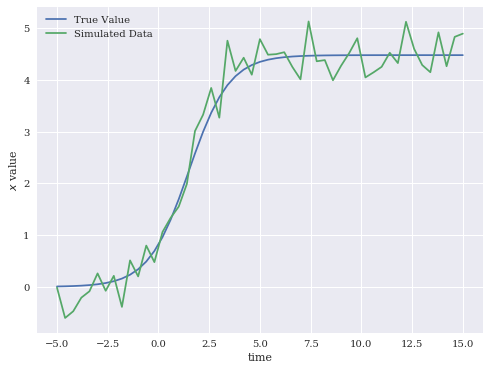

In [28]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sim_df["true_values"])
plt.plot(sim_df["sim_values"])
plt.grid(True)
plt.xlabel("time")
plt.ylabel("$x$ value")
plt.legend(["True Value", "Simulated Data"])
plt.show()

## Likelihood

$$ p(\lambda, K \mid \mathbf{y}) = \frac{p(\mathbf{y} \mid K, \lambda) p(K, \lambda)}{p(\mathbf{y})} =  \frac{p(\mathbf{y} \mid K, \lambda) p(K) p(\lambda)}{p(\mathbf{y})}$$

Now, we define the likelihood distribution. $Y_1, Y_2,..., Y_m$ are the random variables of the realisations/experimental data $ \mathbf{y} = (y_1, y_2,..., y_m)$ so that:

$$ Y_i \mid K, \lambda \sim \text{Norm}( x(t_i), \tau^2) $$

We can therefore simplify our posterior from:

$$ p(\lambda, K \mid \mathbf{y}) \propto p(\lambda, K)p(\mathbf{y} \mid \lambda, K) $$

to:

$$ p(\lambda, K \mid \mathbf{y}) \propto p(\lambda)p(K)\prod_{i=1}^m \text{N}(y_i \mid x( t_i; \lambda, K), \tau^2) $$

In [0]:
def likelihood(observation, lambda_value, k_value, t):
    return norm.pdf(observation, diff_eqn_solution(lambda_value, k_value, t), tau)

## Posterior via MCMC (Metropolis Hastings)

Below I will briefly describe the MH algorithm that will be implemented. Firstly we wish to sample from the the target distribution $p(\lambda, K \mid \mathbf{y})$ which we do so by following the following algorithm. 

Suppose we have a state $X^{(t)} = (K^{(t)}, \lambda^{(t)})$ then we generate a new sample using a proposal distribution $q$.


Generate $Y^{(t)} \sim q(y \mid X^{(t)})$

Move to the new position $X^{(t+1)}$, where:
\begin{equation}
  X^{(t+1)}=\begin{cases}
    Y^{(t)} \: \text{with probability} \:\alpha.\\
    X^{(t)} \: \text{with probability} \:  1-\alpha.
  \end{cases}
\end{equation}

Where 

\begin{equation}
\alpha = \min\left\{ 1, \frac{p(Y^{(t)} \mid \mathbf{y})q(Y^{(t)} \mid X^{(t)})}{p(X^{(t)} \mid \mathbf{y})q(X^{(t)} \mid Y^{(t)})} \right\} 
\end{equation}

For a Guassian proposal distribution, the $q(\cdot)$ terms in the calculation of $\alpha$ disappear because of the symmetry of the distribution. 

In this example we will define our proposal distribution by a Guassian with mean of the current state and a diagonal covariance matrix $\Sigma$, that is:

$$ Y^{(t)} \sim N(X^{(t)}, \Sigma) $$

In [0]:
def mh_posterior(likelihood, prior):
    return likelihood*prior

def mh_prior(lambda_val, k_val):
    #Remembering that in this case we assumed that our priors are independent apriori.
    return norm.pdf(lambda_val, mu_0, sig_0)*norm.pdf(k_val, mu_1, sig_1)

def mh_likelihood(sim_df, lam_val, k_val):
    product = 1.0
    for i in range(len(sim_df)):
        t = round(sim_df.index[i], 1)
        product = product * norm.pdf(sim_df["sim_values"].iloc[i], diff_eqn_solution(lam_val, k_val, t), tau)
    return product
        
def q_dist(x_t, C):
    #proposal distribution from state x_t with meant x_t and covar matrix C
    return np.random.multivariate_normal(x_t, C)

In [0]:
#Apriori independent priors

C = np.array([[0.1, 0], 
              [0, 0.5]])

In [0]:
def mh_algorithm(x_0, no_of_cycles):
    #x_0 is the tuple x_0= (lam_0, k_0)
    hist_of_moves = pd.DataFrame(columns = ["lambda", "k"])
    hist_of_moves = hist_of_moves.append(pd.DataFrame([[x_0[0],x_0[1]]], columns = ["lambda", "k"]))
    x_t = x_0
    for i in range(no_of_cycles):
        #generate a new move from x_0
        lam_t, k_t = x_t[0], x_t[1]
        y_t = q_dist(x_t, C)
        p_x = mh_posterior(mh_likelihood(sim_df, x_t[0], x_t[1]), mh_prior(x_t[0], x_t[1]))
        p_y = mh_posterior(mh_likelihood(sim_df, y_t[0], y_t[1]), mh_prior(y_t[0], y_t[1]))
        comparison  = p_y/p_x
        alpha = min(comparison, 1)
        rand_number = np.random.uniform(0,1)
        if rand_number > 1-alpha:
            x_new = y_t
        else:
            x_new = x_t
        hist_of_moves = hist_of_moves.append(pd.DataFrame([[x_new[0], x_new[1]]], columns = ["lambda", "k"]))
        x_t = x_new
    print("Completed: " + str(no_of_cycles) + " cycles")
    hist_of_moves = hist_of_moves.reset_index()
    hist_of_moves = hist_of_moves.drop(["index"], axis=1)
    return hist_of_moves

## Performing MCMC

In [33]:
import time
start = time.time()
hist = mh_algorithm((1,4), 50000)
end = time.time()
print("MH algorithm took: " + str(end - start) + "seconds to complete")

Completed: 50000 cycles
MH algorithm took: 835.1528420448303seconds to complete


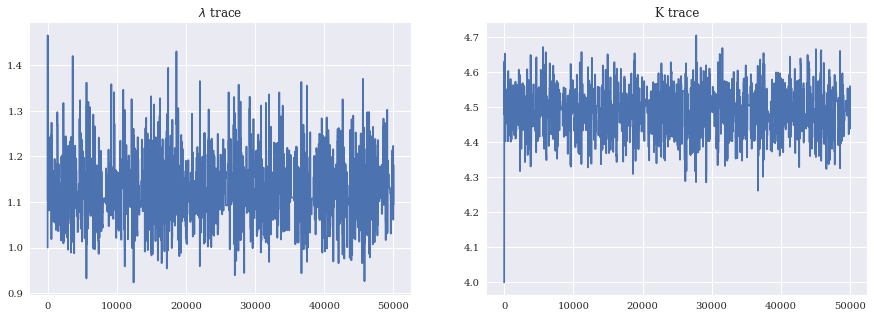

In [58]:
#Plotting the traces of the MCMC algorithm for both lambda and K

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(15)
ax1.plot(hist["lambda"])
ax1.set_title("$\lambda$ trace")
ax2.plot(hist["k"])
ax2.set_title("K trace")
plt.show()

## Posterior Distribution

Now we want to look at the posterior distribution having observed the data and look at our updated beliefs about the values of the parameters $\lambda$ and $K$.

In [0]:
from mpl_toolkits.mplot3d import Axes3D

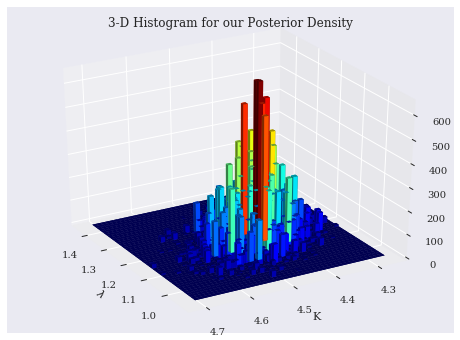

In [75]:
xAmplitudes = hist["lambda"][20:]
yAmplitudes = hist["k"][20:]

x = np.array(xAmplitudes, dtype = 'float64')   #turn x,y data into numpy arrays
y = np.array(yAmplitudes, dtype = 'float64')

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

histo, xedges, yedges = np.histogram2d(x, y, bins=(45,45))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = histo.flatten()

cmap = plt.cm.get_cmap('jet') # Get desired colormap
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
plt.title("3-D Histogram for our Posterior Density")
plt.xlabel("$\lambda$")
plt.ylabel("K")
ax.view_init(30, 150)

plt.show()

We can also look at the marginal posterior density as shown in the graph on the left. In addition to this we can also use Kernel Desnity Estimation to smooth our distribution as shown in the plot to the right.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


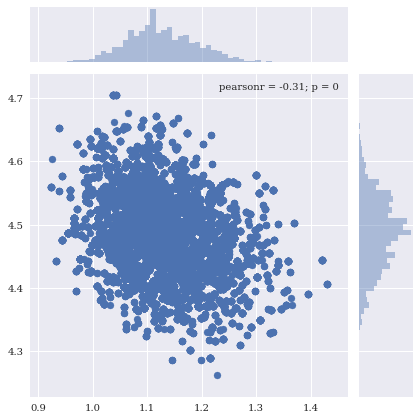

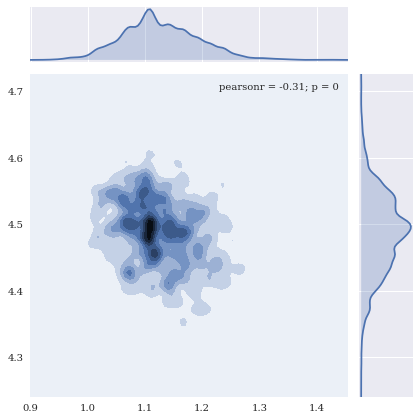

In [101]:
import seaborn as sns
sns.jointplot(x=x, y=y, kind='scatter')

sns.jointplot(x=x, y=y, kind='kde')

## Convergence Diagnostics

Although we have ran the Metropolis-Hastings algorithm to try estimate the posterior distribution, we do not know if the chain has actually converged to the true distribution. We will now look at trying to quantify if the chain has converged to our target distribution by using the $\hat R$ method (Gelman, 1992). A description of this statistic can be found here: https://arxiv.org/pdf/1812.09384.pdf. First, we want to run $m$ chains independently for $2n$ steps.